In [10]:
from __future__ import division
import numpy as np
import matplotlib
from scipy.signal import welch, periodogram, butter, sosfiltfilt

font = {'weight' : 'bold', 'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (10, 8)
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from src.makeLISAdata import LISAdata

### Recover sigma in time domain

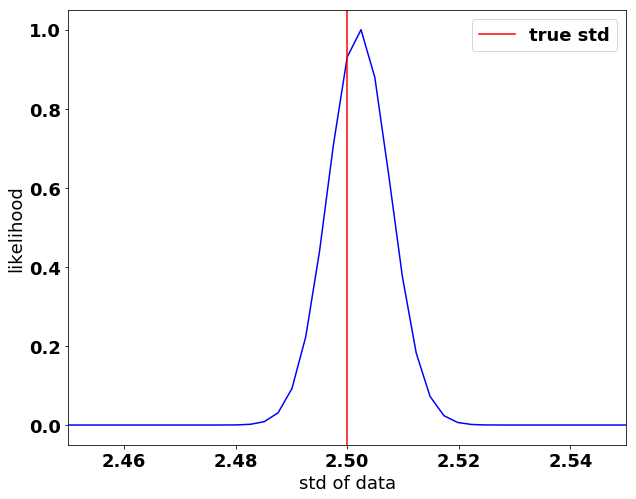

In [11]:
def time_domain(tsig=2.5, fs=256, dur=10, doplot=0):

    nperseg = int(fs*dur)

    data = np.random.normal(scale=tsig, size=nperseg)

    if doplot:
        sig_vals = np.linspace(0.1*tsig, 10*tsig, 10000)

        loglike = np.zeros(sig_vals.shape)

        for ii in range(sig_vals.size):
            loglike[ii] = -0.5*np.sum(data**2/(sig_vals[ii]**2) + np.log(2*np.pi*(sig_vals[ii])**2))
    

        like = np.exp(loglike - loglike.max())
        plt.plot(sig_vals, like, color='b')
        plt.axvline(tsig, color='r', label='true std')
        plt.xlim(0.98*tsig, 1.02*tsig)
        plt.xlabel('std of data')
        plt.ylabel('likelihood')
        plt.legend()
    return data    
################################################################
data = time_domain(tsig=2.5, fs=1024, dur=100, doplot=1)

### Now recover sigma in freq domain

In [19]:
##First bandpass
def freq_domain(tsig=3, fmin=10, fmax=100, fs=256, diagplot=0, dur=10):
    
    ## bandpass
    dobandpass = 0
    
    nperseg = int(fs*dur)

    
    ## determine pass band frequencies which are to be slightly higher
    fmin_pass, fmax_pass = 0.5*fmin,1.1*fmax 
    
    ## get time domain data
    data = time_domain(tsig=tsig, fs=fs, dur=dur, doplot=0)
    
    ## Band pass
    if dobandpass:
        sos = butter(32, [2*fmin_pass/fs, 2*fmax_pass/fs], btype='bandpass', output='sos')
        data = sosfiltfilt(sos, data)
        psd_theor = np.std(data)**2/(fmax_pass - fmin_pass)
    else:
        psd_theor = 2*tsig**2/fs
    
    ## FFT
    hwin = np.hanning(data.size)
    win_fact = np.mean(hwin**2)
    rtilda = np.sqrt(2/(dur*win_fact*fs**2)) * np.fft.rfft(data*hwin, n=nperseg)
    freqs = np.fft.rfftfreq(nperseg, d=1.0/fs)
    fidx = np.logical_and(freqs >= fmin, freqs <= fmax)
    freqs, rtilda = freqs[fidx], rtilda[fidx]


    if diagplot:
        fi, si = welch(data, fs=fs, nperseg=int(1*fs))
        plt.semilogy(fi, si)
        plt.semilogy(freqs, np.abs(rtilda)**2)
        plt.axhline(psd_theor, color='r')
        plt.ylim(3e-1, 2)
        
    return freqs, rtilda, psd_theor
#################################################################################

#freqs, rtilda, psd_theor = freq_domain(tsig=13.56, fmin=5, fmax=200, fs=512, diagplot=0)

In [56]:
def fd_likelihood(dur=10):
    
    freqs, rtilda, psd_theor = freq_domain(tsig=4, fmin=2, fmax=230, fs=512, dur=dur)
    

    Sh = np.linspace(0.1*psd_theor,10*psd_theor, 5000)
    floglike = np.zeros(Sh.shape)

    for ii in range(Sh.size):    
        floglike[ii] = -np.sum(np.abs(rtilda)**2/(Sh[ii]) + np.log(2*np.pi*Sh[ii]))
 
    #import pdb; pdb.set_trace()
    flog = np.exp(floglike - floglike.max())
    plt.plot(Sh, flog, label='likelihood of PSD')
    plt.axvline(psd_theor, color='r', label='true')
    plt.xlim(0.90*psd_theor, 1.1*psd_theor)
    plt.xlabel('PSD of the band limited white noise')
    plt.ylabel('p')
    plt.legend()
    
##################################################

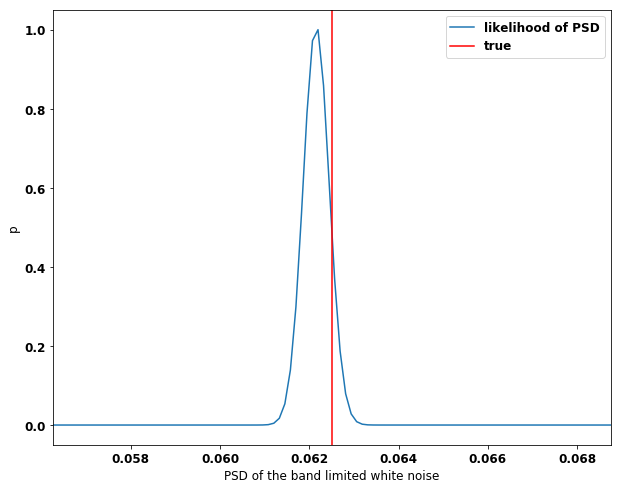

In [57]:
fd_likelihood(dur=200)